# MNIST手写数字识别的FC方法
# 1、数据集介绍
MNIST 包括6万张28x28的训练样本，1万张测试样本，很多教程会首先拿它下手，几乎成为一个 “典范”，可以说它就是计算机视觉里面的Hello World。所以我们这里也会使用MNIST来进行实战。

train-images-idx3-ubyte.gz:  training set images (9912422 bytes) 

train-labels-idx1-ubyte.gz:  training set labels (28881 bytes) 

t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)

t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)




In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.Size([1, 28, 28])
5
tensor(5)


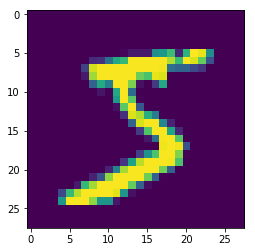

tensor(0)


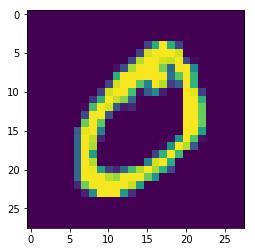

tensor(4)


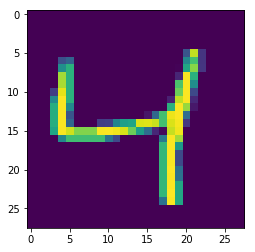

tensor(1)


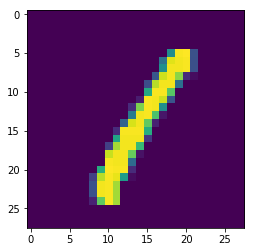

tensor(9)


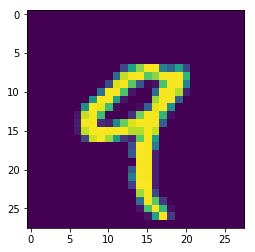

tensor(2)


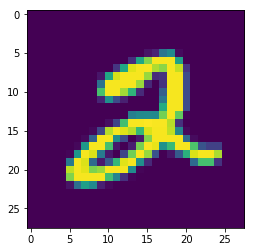

tensor(1)


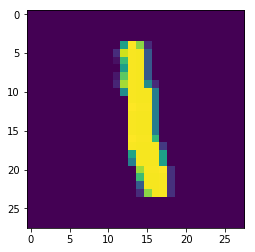

tensor(3)


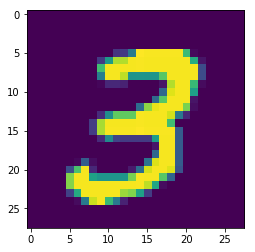

tensor(1)


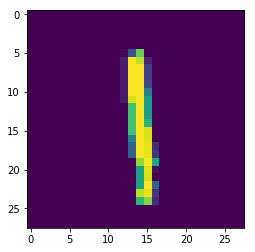

tensor(4)


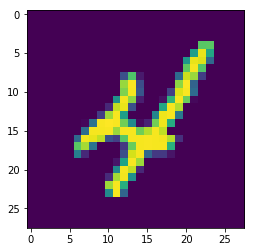

tensor(1) tensor(9) tensor(9) tensor(0) tensor(9) tensor(1) tensor(7) tensor(2) tensor(4) tensor(1) tensor(3) tensor(2) tensor(3) tensor(8) tensor(1) tensor(9) tensor(2) tensor(6) tensor(2) tensor(4) tensor(0) tensor(7) tensor(1) tensor(7) tensor(4) tensor(1) tensor(1) tensor(6) tensor(7) tensor(6) tensor(5) tensor(1) tensor(9) tensor(7) tensor(3) tensor(3) tensor(9) tensor(9) tensor(3) tensor(8) tensor(7) tensor(9) tensor(7) tensor(9) tensor(2) tensor(4) tensor(3) tensor(4) tensor(5) tensor(9) tensor(9) tensor(6) tensor(8) tensor(0) tensor(2) tensor(3) tensor(6) tensor(7) tensor(5) tensor(2) tensor(4) tensor(1) tensor(4) tensor(8)


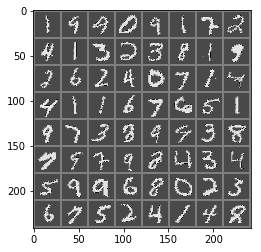

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
'''
不同数据集就有不同的标准化系数，例如
([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])就是
Imagenet dataset的标准化系数（RGB三个通道对应三组系数）
'''
train_data=datasets.MNIST('mnist', train=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
a_data, a_label = train_data[0]
print(a_data.shape)
print(a_label)   
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


def imshow(img):
    img = img / 2 + 0.5     # 映射到区间[0,1]
    #print(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    
for i in range(10):
    image_array,_=train_data[i]#打印第i个
    image=image_array.reshape(28,28)
    image=image/2+0.5
    #print(image)
    print(train_data.targets[i])#打印出标签
    plt.imshow(image)
    plt.show()
    
# 获取随机数据
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%5s' % labels[j] for j in range(64)))

In [3]:
class SimpleNet(nn.Module):
    def __init__(self, in_dim, hidden_1, hidden_2, out_dim):
        super(SimpleNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, hidden_1),
            nn.BatchNorm1d(hidden_1), nn.ReLU(True))
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_1, hidden_2),
            nn.BatchNorm1d(hidden_2), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(hidden_2, out_dim))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


# 加载MNIST数据集
在pytorch下可以直接调用torchvision.datasets里面的MNIST数据集（这是官方写好的数据集类）

In [7]:
# 超参数
batch_size = 64
learning_rate = 1e-2

if __name__ == '__main__':
    data_tf = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST(
        root='./mnist', train=True, transform=data_tf, download=False)
    test_dataset = datasets.MNIST(root='./mnist', train=False, transform=data_tf)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(len(test_loader))
    model = SimpleNet(28 * 28, 300, 100, 10)
    if torch.cuda.is_available():
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    #创建图并命名
    plt.figure('Loss')
    iter_plot = []
    loss_plot = []
    for epoch in range(1):
        print("第%d轮迭代"%(epoch+1))
        t=0
        for data in train_loader:
            img, label = data
            img = img.view(img.size(0), -1)
            #print(img.shape)  (64,784)
            if torch.cuda.is_available():
                img = img.cuda()
                label = label.cuda()
            
            out = model(img)
            loss = criterion(out, label)
            print_loss = loss.data.item()
            iter_plot.append(t)
            loss_plot.append(print_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t+=1
            if t%100==0:
                print('iter: {}, loss: {:.4}'.format(t, loss.data.item()))
    model.eval()
    eval_loss = 0
    eval_acc = 0
    flag=True
    for data in test_loader:
        img, label = data
        img = img.view(img.size(0), -1)
        if torch.cuda.is_available():
            img = img.cuda()
            label = label.cuda()
        else:
            img = Variable(img)
            label = Variable(label)
        out = model(img)
        loss = criterion(out, label)
        print(label.size(0))
        eval_loss+=loss.data.item()*label.size(0)
        #print(out.shape)   (64,10)
        _, pred = torch.max(out, 1)
        if flag:
            print('真实数字：')
            print(label)
            print('预测数字：')
            print(pred)
            flag=False
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(
        eval_loss / (len(test_dataset)),
        eval_acc / (len(test_dataset))
    ))



157
第1轮迭代
iter: 100, loss: 1.398
iter: 200, loss: 1.067
iter: 300, loss: 0.8754
iter: 400, loss: 0.6537
iter: 500, loss: 0.595
iter: 600, loss: 0.4864
iter: 700, loss: 0.3958
iter: 800, loss: 0.3251
iter: 900, loss: 0.312
64
真实数字：
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])
预测数字：
tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64

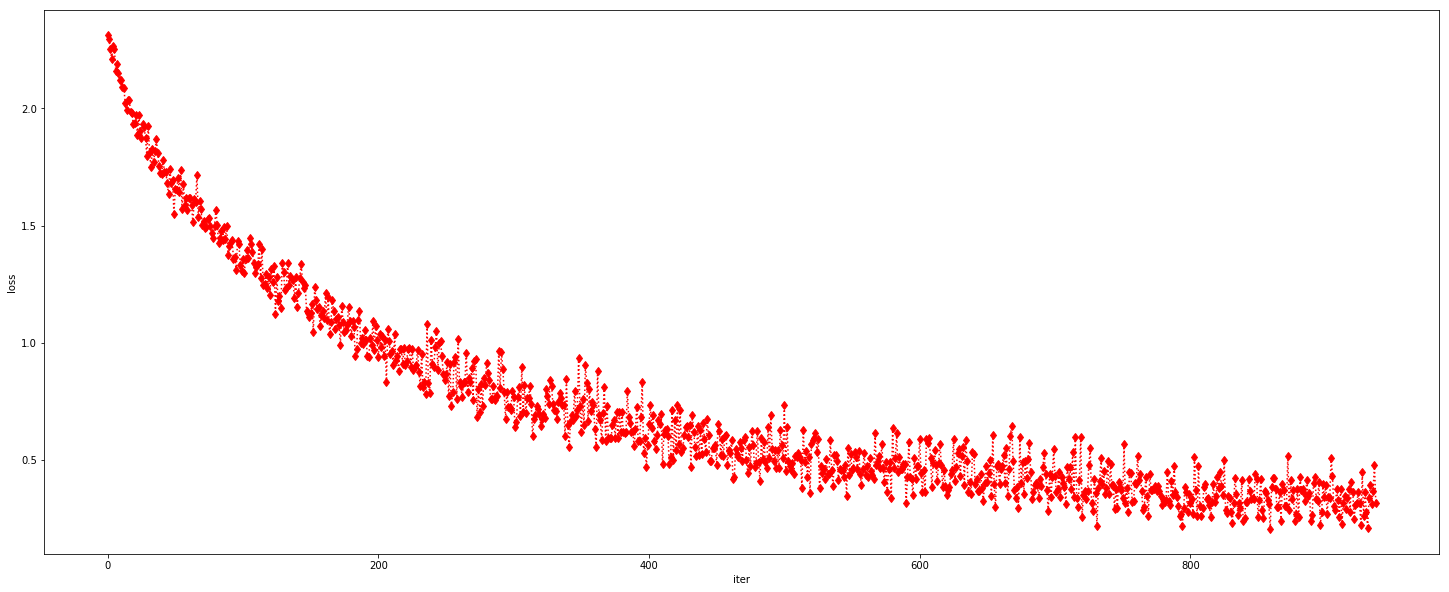

In [5]:
plt.figure(figsize=(25,10))
ax = plt.subplot()
#设置x轴、y轴名称
ax.set_xlabel('iter')
ax.set_ylabel('loss')
plt.plot(iter_plot,loss_plot,marker='d',linestyle=':',color='r')
plt.show()